# Implementing time-varying covariates

In this notebook, we analyse a simulated dataset with time-varying covariates and survival outcomes. `TorchSurv` is used to train a model that predicts relative risk of subjects based on covariates observed over time. We will attempt to thoroughly explain the necessary elements to understand our implementation, but for a detailed read on time-varying survival models refer to Chapter 6 of [Dynamic Regression Models for Survival Data](https://link.springer.com/book/10.1007/0-387-33960-4). 

### Dependencies

To run this notebook, dependencies must be installed. the recommended method is to use our developpment conda environment (**preffered**). Instruction can be found [here](https://opensource.nibr.com/torchsurv/devnotes.html#set-up-a-development-environment-via-conda) to install all optional dependancies. The other method is to install only required packages using the command line below:

## Implementing partial log likelihood for time-varying covariates

### Context and statistical set-up

Let $i$ e the index for some subject $i$ with a failute time denoted as $\tau^*_i$ and $C$ be the censoring time. For the moment $C$ remains constant but there are extensions that allow for $C$ to vary over $i$. Let $\tau_i = min(\tau^*_i, C)$. We use $\delta_i$ to denote whether $\tau^*_i$ was observed. 

We will use $Z(t)$ to denote the value of of covariate $Z$ and time $t$. 
We use $Z(t)$ to denote the value of Z at time $t$ and $\overline{Z}(t)$ to denote the set of covariates from the beggining up to time $t$: $ \overline{Z}(t) = \{ Z(s): 0 \leq s \leq t\}$.
Let $t_k$ for $k \in \{1, \dots, K\} denote the time points at which the covariates are observed. For the moment, we assume that all subjects have been observed on the same time grid. $R_k$ is the set of individuals who are at risk at $t_k$. 

The conditional hazard function of $T$ given $\overline{Z}(t)$ is defined as
$$ \lambda(T|\overline{Z}(t)) = Pr(T \in [t, t+ dt)|T \geq t, \overline{Z}(t)), $$
in other words, it is the probability that an event will occur in the next time instance if we have observed covariates up to time $t$ and that a subject has not yet experienced an event.

The typical cox proportional hazards model with constant covariates $Z$ assumes a constant hazard ratio: $\lambda(T|Z)= \lambda_0(t) exp(\beta Z)$, where $\beta$ in an unknown set of regression parameters and $\lambda_0(t)$ is an unspecified baseline hazard function. In this case $\frac{\lambda(T|Z)}{\lambda_0(t)} = exp(\beta Z) $. The cumlative hazard ia defined as $\Lambda(t) = \int_0^t \lambda(s)ds$. 

In a time varying cox model, the hazard ratio is now dependant on time:
$$ \frac{\lambda(t|Z)}{\lambda_0(t)} = exp(\beta Z(t)) $$ 
and the proportinal hazard model specifies:
$$ \lambda(t|Z) = \lambda_0(t)exp(\beta Z(t)) $$

Let $i_j$ denote the label or identity of the individual who fails at time $\tau_j$, including the value of their time-varying covariate
during their time in the study $\{ Z_{i_j}(t): t \in [0, \tau_j] \}$. The partial likelihood is:
$$ L (\beta) = \prod_j \Big (\frac{\lambda(\tau_j: Z_i(\tau_j)))}{\sum_{l \in R_i} \lambda(\tau_j: Z_l(\tau_j)))} \Big),$$
in terms of the model form:
$$ L (\beta) = \prod_j \Big (\frac{\exp(\beta Z_i(\tau_j))}{\sum_{j \in R_i} \exp(\beta Z_i(\tau_j))} \Big).$$

Taking the log on both sides, we get the partial log-likelihood:
$$ \log L (\beta) = \sum_j \Big (\beta Z_i(\tau_j)) - \log [\sum_{j \in R_i} \exp(\beta Z_i(\tau_j))]\Big ). $$


### Extension to neural networks

Consider a more genera form, where we have the cox proportional hazards model:
$$\lambda(T|\overline{Z}(t))= \lambda_0(t) \theta(Z(t))$$

Additionally, consider some network that maps the input covariates $Z(t)$ to the log relative hazards: $\log \theta(Z(t))$.

The partial likelihood with repsect to $\theta(Z(\tau_j))$ is written as:
$$ \log L(\theta) = \sum_j \Big( \log \theta(Z_i(\tau_j)) - \log [\sum_{j \in R_i} \theta (Z_i(\tau_j))] \Big).$$
It onlu considers the covariate values at the time of event or censoring denoted as $\tau_j$, all prior covariates are not considered.

As the output of the network is set to be $\log \theta(Z(t))$, the code is written to account for this, to show this explicitly, set $\phi(Z(t)) = \log \theta(Z(t))$ and write the log likelihood in terms oh $phi$:

$$ \log L(\theta) = \sum_j \Big( \phi(Z_i(\tau_j)) - \log [\sum_{j \in R_i} \exp \phi(Z_i(\tau_j))] \Big).$$


In [1]:
# Install only required packages (optional)
# %pip install lifelines
# %pip install matplotlib
# %pip install sklearn
# %pip install pandas

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Our package
#from torchsurv.loss.time_varying import neg_partial_log_likelihood2

# PyTorch boilerplate - see https://github.com/Novartis/torchsurv/blob/main/docs/notebooks/helpers_introduction.py
from helpers_introduction import Custom_dataset, plot_losses

## Simulating a dataset

We will simulate a dataset of 100 subjects with 10 follow up times where a covariate is observed. The covariates will follow a trigonometric function over time and will be dependant on a random variable to differentiate between subjects.

For each $i$ the covariate follows the function:

$$ Z_i(t) = a_i \cos(2 \pi t) $$

where $a_i \sim N(5, 2.5)$.

In [7]:
torch.manual_seed(123)

# defining parameters
sample_size = 100  #number of subjects to generate
obs_time = 10 #number of observations over time for each subject

# create random variables following a normal distribution N(1,1) for each subject 
mean = 5
standard_dev = 2.5
random_vars = torch.randn(sample_size)*standard_dev + mean

# using the random variables from above, we create a set of covariates for each subject 
t = torch.linspace(0, 2*math.pi, obs_time)  # Generating 6 equidistant time points from 0 to 2*pi

# Creating the matrix
matrix = torch.zeros(sample_size, obs_time)

# Filling the matrix with sin values
for i in range(obs_time):
    matrix[:, i] = torch.cos(t[i])

# Multiplying with a vector of random variables, dim sample_size x obs_time
covars = matrix * random_vars[:, None]


Now we create outcome variables for the dataset based on the random variables we generated initially. This is so that the observations are related to the outcome in some way so that our network can distinguish some pattern.

We use the random variables ot determine how long someone has been observed and when they experience an event (if they experience one). Then we remove observations for the times beyond their event time.

### Data Format

Here we create a single matrix of data that corresponds to one covariate being observed over time for some dataset.
The time series is padded with zeros so that each subject has the same legth vector, the vector contains their covariate $Z_i(t)$ up until failure time $\tau_j$ and then values beyond that are zero.

In general, prior to fitting a survival model or a network, one should consider ohw to handle missing data beforehand. This is most important for covariates that are missing at event time $\tau_j $. Data imputation methods can vary depending on the use case but some to consider are:
- use the most recent value (assumes step function),
- interpolate,
- impute based on some model.

In [ ]:
# make random positive time to event
time =  torch.floor(random_vars)
# print(time)  
# tensor([1.2792e+01, -7.7415e+00,  9.2325e+00,  1.0845e+01,  7.6460e+00, ...

# decide who has an event, here we cosnider those whose time is greater than one and smaller than 9
events = (time > 1) & (time < 8)
# tensor([ True,  True, False, False,  True,  ...
# print(events)

# remove the covariates for those who have observed an event

for i in range(sample_size):
    if events[i]==True:
        time_cap = int(time[i])
        covars[i, time_cap:] = torch.zeros(obs_time-time_cap)

# covars should be tensor([[ 3.3737e-01,  2.5844e-01,  5.8584e-02, -1.6869e-01, -3.1702e-01, ... 
# and zeros after an event occured

# print(covars)

## Training the RNN 

Below we will give an example set up of how to use the partial log likelihood in a loss function. We import the python file containg the loss and set up an RNN to work with our simulated data.

In [24]:
from loss_time_covariates import neg_partial_time_log_likelihood

In [22]:
#from torchsurv.loss import time_covariates
#from torchsurv.metrics.cindex import ConcordanceIndex

# Parameters
input_size = 1
output_size = 1
num_layers = 2
seq_length = obs_time
batch_size = sample_size

# Create simple RNN model
rnn = torch.nn.RNN(input_size, output_size, num_layers)
inputs = torch.randn(seq_length, batch_size, input_size)
test = covars.T.unsqueeze(2)
print(test.shape)
print(inputs.shape)

#initializa hidden state
h0 = torch.randn(num_layers, batch_size, output_size)
print(h0.shape)
# Forward pass time series input
outputs, _ = rnn(test, h0)
print(outputs.shape)
# estimates = outputs[-1]  # Keep only last predictions, many to one approach
# print(estimates.size())  # torch.Size([8, 1])
# print(f"Estimate shape for {batch_size} samples = {estimates.size()}")  # Estimate shape for 8 samples = torch.Size([8, 1])


# loss = cox.neg_partial_log_likelihood(estimates, events, time)
# print(f"loss = {loss}, has gradient = {loss.requires_grad}")  # loss = 1.0389232635498047, has gradient = True

# cindex = ConcordanceIndex()
# print(f"c-index = {cindex(estimates, events, time)}")  # c-index = 0.20000000298023224

torch.Size([10, 100, 1])
torch.Size([10, 100, 1])
torch.Size([2, 100, 1])
torch.Size([10, 100, 1])


## Comparison to Lifelines package

Re-format the simulaiton data to fit a normal time-varying cox model in the lifelines package.

In [9]:
import pandas as pd

# as a reminder covars is the matrix of covariates where a row corresponds to a subject and a column corresponds to their observation at some time 
# the columns are padded so if a subject experiences an event, the remaining of the column is zero

# Generating example torch matrix
torch_matrix = covars
# Convert torch matrix to pandas dataframe

#set time to integer
max_time = max(time.type(torch.int64))

vars = []
#times = []
start = []
stop = []
events = []
subjs = []
for i in range(sample_size):
    subj_counter = 0
    for j in range(max_time):
        if torch_matrix[i,j] == 0:
            break
        else:
            vars.append(torch_matrix[i,j].item())
            #times.append(j)
            start.append(j-1)
            stop.append(j)
            events.append(False)
            subj_counter += 1
    subjs.extend([i] * subj_counter)
    events[-1]=True

df = pd.DataFrame({
    "subj": subjs,
    #"times": times,
    "start":start,
    "stop": stop,
    "events": events,
    "var": vars, 
})


Iteration 1: norm_delta = 2.11e-02, step_size = 0.9500, log_lik = -363.73938, newton_decrement = 5.00e-02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.05e-03, step_size = 0.9500, log_lik = -363.68954, newton_decrement = 1.24e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.24e-05, step_size = 0.9500, log_lik = -363.68942, newton_decrement = 3.09e-07, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.76e-06, step_size = 1.0000, log_lik = -363.68942, newton_decrement = 7.73e-10, seconds_since_start = 0.0
Convergence completed after 4 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 778 periods, 100 subjects, 100 events>
         event col = 'events'
         penalizer = 0.1
number of subjects = 100
 number of periods = 778
  number of events = 100
partial log-likelihood = -363.69
  time fit was run = 2024-12-13 16:55:56 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
var       -0.03      0.97      0.09           -0.21            0.15                0.81                1.16

           cmp to     z    p  -log2(p)
covariate                             
var          0.00 -0.32 0.75      0.41
---
Partial AIC = 729.38
log-likelihood ratio test = 0.10 on 1 df
-log2(p) of ll-ratio test = 0.41

<Axes: xlabel='log(HR) (95% CI)'>

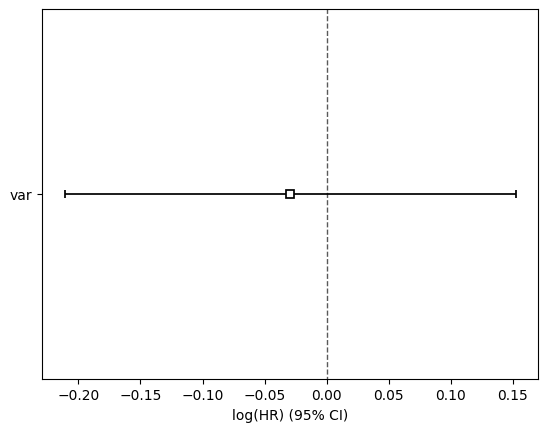

In [11]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(df, id_col="subj", event_col="events", start_col="start", stop_col="stop", show_progress=True)
ctv.print_summary()
ctv.plot()

## Testing it on the lifelines dataset

This is to demonstrate the method with a neural network, example inspired by the [lifelines example](https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html#).

This is a classic dataset for survival regression with time varying covariates. The original dataset is from J Crowley and M Hu. 'Covariance analysis of heart transplant survival data', and this dataset is from R’s survival library.


In [12]:
import lifelines

df = lifelines.datasets.load_stanford_heart_transplants()
df.head(5)

,start,stop,event,age,year,surgery,transplant,id
0,0.0,50.0,1,-17.155373,0.123203,0,0,1
1,0.0,6.0,1,3.835729,0.254620,0,0,2
2,0.0,1.0,0,6.297057,0.265572,0,0,3
3,1.0,16.0,1,6.297057,0.265572,0,1,3
4,0.0,36.0,0,-7.737166,0.490075,0,0,4


The dataset contains the following:

- `start`: entry time,
- `stop`: exit time,
- `event`: status for this interval of time,
- `age`: subjetct's age -48 years,
- `year`: tyear of acceptance (in years after 1 Nov 1967)
- `surgery`: prior bypass surgery 1=yes
- `transplant`: received transplant 1=yes
- `id`: patient id

In [6]:
from lifelines.utils import to_long_format, add_covariate_to_timeline

base_df = pd.DataFrame([
  {'id': 1, 'duration': 10, 'event': True, 'var1': 0.1},
  {'id': 2, 'duration': 12, 'event': True, 'var1': 0.5}
])

base_df = to_long_format(base_df, duration_col="duration")

In [ ]:
# Constant parameters accross models
# Detect available accelerator; Downgrade batch size if only CPU available
if any([torch.cuda.is_available(), torch.backends.mps.is_available()]):
    print("CUDA-enabled GPU/TPU is available.")
    BATCH_SIZE = 128  # batch size for training
else:
    print("No CUDA-enabled GPU found, using CPU.")
    BATCH_SIZE = 32  # batch size for training

EPOCHS = 100
LEARNING_RATE = 1e-2

In [ ]:
df_onehot = pd.get_dummies(df, columns=["horTh", "menostat", "tgrade"]).astype("float")
df_onehot.drop(
    ["horTh_no", "menostat_Post", "tgrade_I"],
    axis=1,
    inplace=True,
)
df_onehot.head(5)

In [ ]:
df_train, df_test = train_test_split(df_onehot, test_size=0.3)
df_train, df_val = train_test_split(df_train, test_size=0.3)
print(
    f"(Sample size) Training:{len(df_train)} | Validation:{len(df_val)} |Testing:{len(df_test)}"
)

In [ ]:
# Dataloader
dataloader_train = DataLoader(
    Custom_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True
)
dataloader_val = DataLoader(
    Custom_dataset(df_val), batch_size=len(df_val), shuffle=False
)
dataloader_test = DataLoader(
    Custom_dataset(df_test), batch_size=len(df_test), shuffle=False
)

In [ ]:
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 1),  # Estimating log hazards for Cox models
)

In [ ]:
# This is for testing the loss function
x_test, (test_event, test_time) = next(iter(dataloader_train))

log_hz = cox_model(x_test)

In [ ]:
print('x_test', x_test.shape)
print('events', test_event.shape)
print('times', test_time.shape)

time_sorted, idx = torch.sort(time)
log_hz_sorted = log_hz[idx]
event_sorted = event[idx]
time_unique = torch.unique(time_sorted)
print('')
print("time_sorted", time_sorted.shape)
print('log_hz_sorted', log_hz_sorted.shape)
print('event_sorted', event_sorted.shape)
print("time_unique", time_unique.shape)

print('-'*30)
cov_fake = torch.clone(x_test)
print('covariates', cov_fake.shape)
covariates_sorted = cov_fake[idx, :]
covariate_inner_product = torch.matmul(covariates_sorted, covariates_sorted.T)
print('cov_inner', covariate_inner_product.shape)
log_nominator_left = torch.matmul(log_hz_sorted.T, covariate_inner_product)
print('log_nom_left', log_nominator_left.shape)
bracket = torch.mul(log_hz_sorted, covariates_sorted)
print('bracket', bracket.shape)
log_nominator_right = torch.matmul(bracket, bracket.T)
print('log_nom_right', log_nominator_right.shape)
sum_nominator_right = log_nominator_right[0,].unsqueeze(0)
print('sum_nom', sum_nominator_right.shape)
log_denominator = torch.logcumsumexp(log_hz_sorted.flip(0), dim=0).flip(0).T
print('log_denom', log_denominator.shape)
last_bit = torch.div(log_nominator_left - sum_nominator_right, log_denominator)
print('last_bit', last_bit.shape)
last_bit


tensor([1.3927, 1.5773, 0.0192, 0.1983])

## RNN Example from Github

In [ ]:
import torch
from torchsurv.loss import cox
from torchsurv.metrics.cindex import ConcordanceIndex

# Parameters
input_size = 10
output_size = 1
num_layers = 2
seq_length = 5
batch_size = 8

# make random boolean events
events = torch.rand(batch_size) > 0.5
print(events)  # tensor([ True, False,  True,  True, False, False,  True, False])

# make random positive time to event
time = torch.rand(batch_size) * 100
print(time)  # tensor([32.8563, 38.3207, 24.6015, 72.2986, 19.9004, 65.2180, 73.2083, 21.2663])

# Create simple RNN model
rnn = torch.nn.RNN(input_size, output_size, num_layers)
inputs = torch.randn(seq_length, batch_size, input_size)
h0 = torch.randn(num_layers, batch_size, output_size)

# Forward pass time series input
outputs, _ = rnn(inputs, h0)
estimates = outputs[-1]  # Keep only last predictions, many to one approach
print(estimates.size())  # torch.Size([8, 1])
print(f"Estimate shape for {batch_size} samples = {estimates.size()}")  # Estimate shape for 8 samples = torch.Size([8, 1])


loss = cox.neg_partial_log_likelihood(estimates, events, time)
print(f"loss = {loss}, has gradient = {loss.requires_grad}")  # loss = 1.0389232635498047, has gradient = True

cindex = ConcordanceIndex()
print(f"c-index = {cindex(estimates, events, time)}")  # c-index = 0.20000000298023224